### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/mumtozee/NeuralMachineTranslation

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import yaml
from src.data.datamodule import DataManager
from src.txt_logger import TXTLogger
%reload_ext autoreload
%autoreload 2
from src.models.seq2seq_transformer import Seq2SeqTransformer
from src.models import trainer

In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [4]:
data_config = yaml.load(open("configs/data_config.yaml", "r"), Loader=yaml.Loader)
dm = DataManager(data_config, DEVICE)
train_dataloader, dev_dataloader = dm.prepare_data()

Reading from file: 100%|█████████████████████████████████████████████████████| 467119/467119 [00:06<00:00, 72800.28it/s]


In [5]:
len(train_dataloader.dataset), len(dev_dataloader.dataset)

(5301, 1326)

In [6]:
dm.source_tokenizer.tokenizer.get_vocab_size(), dm.target_tokenizer.tokenizer.get_vocab_size()

(4285, 7497)

In [15]:
batch = next(iter(train_dataloader))
batch[0].shape

torch.Size([128, 64])

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [7]:
model_config = yaml.load(open("configs/model_config.yaml", 'r'),   Loader=yaml.Loader)
model_config["device"] = DEVICE
model_config["tgt_vocab_size"] = dm.target_tokenizer.tokenizer.get_vocab_size()
model_config["src_vocab_size"] = dm.source_tokenizer.tokenizer.get_vocab_size()
model = Seq2SeqTransformer(model_config).to(DEVICE)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [8]:
model_config

{'nhead': 8,
 'emb_size': 512,
 'dim_feedforward': 512,
 'num_encoder_layers': 6,
 'num_decoder_layers': 6,
 'dropout': 0.1,
 'lr': 0.0001,
 'weight_decay': 0.03,
 'epoch_num': 100,
 'try_one_batch': False,
 'device': 'cuda',
 'tgt_vocab_size': 7497,
 'src_vocab_size': 4285}

In [9]:
import warnings
warnings.filterwarnings(action="ignore", category=UserWarning)

logger = TXTLogger("training_logs")
trainer_cls = trainer.Trainer(
    model=model,
    model_config=model_config,
    logger=logger,
    target_tokenizer=dm.target_tokenizer,
)

if model_config["try_one_batch"]:
    train_dataloader = [list(train_dataloader)[0]]
    dev_dataloader = [list(train_dataloader)[0]]

trainer_cls.train(train_dataloader, dev_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [10:50<00:00,  6.51s/it]

Last 99 epoch train loss:  0.5753251143864223
Last 99 epoch val loss:  8.929375648498535
Last 99 epoch val bleu:  0.07884834137133039


In [10]:
tmp_batch = next(iter(dev_dataloader))
inp, tgt = tmp_batch[0][:10], tmp_batch[1][:10]
model.eval()
with torch.no_grad():
    out = model.generate(inp)
out.shape

torch.Size([10, 10])

In [11]:
for i in range(10):
    src_decoded = " ".join(dm.source_tokenizer.decode(inp[i].cpu().numpy().tolist()))
    out_decoded = " ".join(dm.target_tokenizer.decode(out[i].cpu().numpy().tolist()))
    tgt_decoded = " ".join(dm.target_tokenizer.decode(tgt[i].cpu().numpy().tolist()))
    print(f"{1 + i}.\tEN: {src_decoded}\n\tRU: {tgt_decoded}\n\tPRED: {out_decoded}")

1.	EN: everybody makes mistakes once in a while
	RU: все время от времени совершают ошибки
	PRED: все ошибаются не может себя
2.	EN: everyone says that he looks just like his father
	RU: все говорят что он выглядит так же как его отец
	PRED: все знают что он так как я пошёл
3.	EN: no one can force you to do anything against your will
	RU: никто не может заставить вас сделать что то против вашей воли
	PRED: никто не может сделать эту заставить меня сделать
4.	EN: electric irons are heated by electricity
	RU: электрические утюги нагреваются от электричества
	PRED: опыт мир работает на здоровья
5.	EN: even though tom had a cold he went to work
	RU: несмотря на простуду том пошёл на работу
	PRED: даже том знает что он заниматься заниматься
6.	EN: our project didn t get off the ground until he joined the company
	RU: наш проект не сдвигался с мёртвой точки пока он не пришёл к нам в компанию
	PRED: всё остальное не смог спать
7.	EN: everybody needs something to believe in
	RU: всем нужно во 

In [12]:
%autoreload 2
from src.data.utils import plot_results

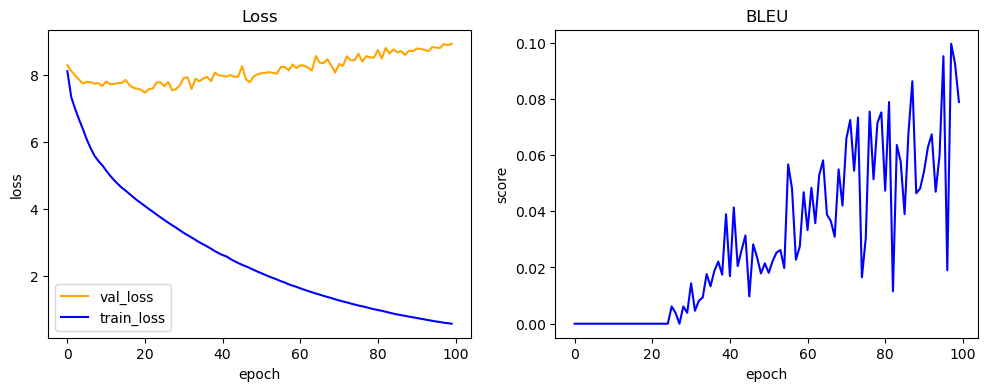

In [14]:
plot_results("./training_logs/transformer_final.txt")

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

# prepare data for T5

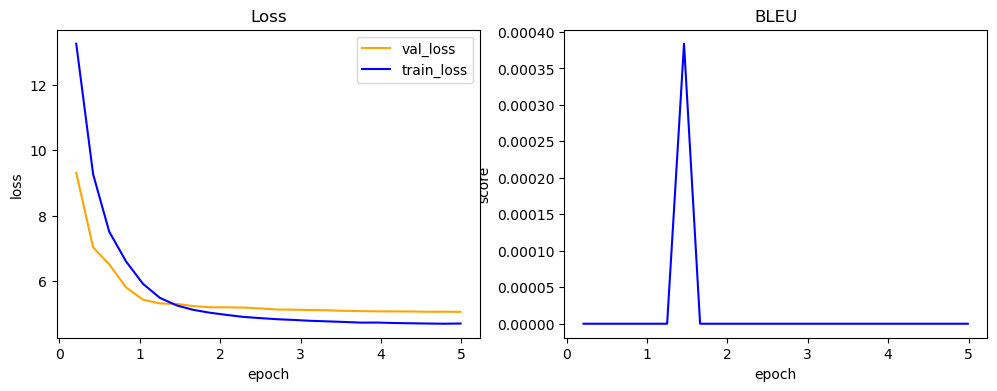

In [9]:
plot_results("./training_logs/t5v1_final.txt")

<strong style="color:red">!!NOTE!!</strong> Результат модели с Т5 с добавлением эмбеддингов для русского языка не оказался удовлетворительным, требуется больше времени и данных для предобучения эмбеддингов. Поэтому я решил использовтаь мультилингуальный Т5 с готовыми эмбеддингами для 101 языков.

In [3]:
from src.data.utils import TextUtils, T2TDataCollator, short_text_filter_function, to_csv

In [5]:
data_config = yaml.load(open("configs/data_config.yaml", "r"), Loader=yaml.Loader)
pairs = TextUtils.read_langs_pairs_from_file(filename=data_config["filename"])
prefix_filter = None
if prefix_filter:
    prefix_filter = tuple(prefix_filter)

source_sentences, target_sentences = [], []
# dataset is ambiguous -> i lied -> я солгал/я соврала
unique_sources = set()
for pair in pairs:
    source, target = pair[0], pair[1]
    if (
        short_text_filter_function(
            pair, data_config["max_length"], prefix_filter
        )
        and source not in unique_sources
    ):
        source_sentences.append(source)
        target_sentences.append(target)
        unique_sources.add(source)

train_size = int(len(source_sentences) * data_config["train_size"])
source_train_sentences, source_val_sentences = (
    source_sentences[:train_size],
    source_sentences[train_size:],
)
target_train_sentences, target_val_sentences = (
    target_sentences[:train_size],
    target_sentences[train_size:],
)

Reading from file: 100%|████████████| 467119/467119 [00:04<00:00, 103372.27it/s]


In [4]:
from transformers import T5TokenizerFast, T5ForConditionalGeneration
from datasets import load_dataset

In [5]:
TOKER_PATH = "google/mt5-small"
# TOKER_PATH = "./tokenizers/ru_eng/"
MODEL_PATH = "google/mt5-small"
# MODEL_PATH = "google/t5-v1_1-small"
t5toker = T5TokenizerFast.from_pretrained(TOKER_PATH)
# new_toker = t5toker.train_new_from_iterator(target_train_sentences, vocab_size=50_000)
# new_added = t5toker.add_tokens(list(new_toker.get_vocab().keys()))
# t5toker.save_pretrained("./tokenizers/ru_eng/")

/home/akhmadjonov/miniconda3/envs/sber/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [14]:
to_csv(source_train_sentences, target_train_sentences, "./train.csv")
to_csv(source_val_sentences, target_val_sentences, "./val.csv")

In [6]:
data = load_dataset(path=".", data_files={"train": "./train.csv", "val": "./val.csv"})
data

Using custom data configuration .-3d4b1b44b0521222
Found cached dataset csv (/home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'ru'],
        num_rows: 245772
    })
    val: Dataset({
        features: ['en', 'ru'],
        num_rows: 61443
    })
})

In [7]:
def tokenize(batch):
    input_enc = t5toker.batch_encode_plus(
        batch["en"], padding="max_length", truncation=True, max_length=64
    )
    target_enc = t5toker.batch_encode_plus(
        batch["ru"], padding="max_length", truncation=True, max_length=64
    )
    encodings = {
        "input_ids": input_enc["input_ids"],
        "attention_mask": input_enc["attention_mask"],
        "labels": target_enc["input_ids"],
        "decoder_attention_mask": target_enc["attention_mask"],
    }
    return encodings


data_enc = data.map(
    tokenize, batched=True, num_proc=4, remove_columns=data["train"].column_names
)
columns = ["input_ids", "labels", "attention_mask", "decoder_attention_mask"]
data_enc.set_format(type="torch", columns=columns)

Loading cached processed dataset at /home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c151c87997bde405.arrow


Loading cached processed dataset at /home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-2e8a4cf193132600.arrow


Loading cached processed dataset at /home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-e51ccf9dd04cb3b3.arrow


Loading cached processed dataset at /home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-d0503b3588534c23.arrow


Loading cached processed dataset at /home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c84e17666257c02d.arrow


Loading cached processed dataset at /home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-fccfd486e78758ab.arrow


Loading cached processed dataset at /home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-f240c832ae71563d.arrow


Loading cached processed dataset at /home/akhmadjonov/.cache/huggingface/datasets/csv/.-3d4b1b44b0521222/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c7284833f498c945.arrow


In [8]:
collator = T2TDataCollator()
tmp1 = data_enc["train"][23]
out = collator([tmp1])
out["labels"]

tensor([[250099,   2839,  58767,    833, 160787,      1,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
           -100]])

# LOAD MODEL & TRAIN

In [8]:
import wandb

wandb.login()

wandb: Currently logged in as: imumtozee. Use `wandb login --relogin` to force relogin


True

In [9]:
%env WANDB_PROJECT=eng_ru_nmt

env: WANDB_PROJECT=eng_ru_nmt


In [9]:
from transformers import (
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
    MT5ForConditionalGeneration,
)

In [11]:
set_seed(42)
# t5 = T5ForConditionalGeneration.from_pretrained(MODEL_PATH)
# t5.resize_token_embeddings(len(t5toker.get_vocab()))
t5 = MT5ForConditionalGeneration.from_pretrained(MODEL_PATH)

In [13]:
len(data_enc["train"]) / 256

960.046875

In [12]:
set_seed(42)

BATCH_SIZE = 64

training_args = Seq2SeqTrainingArguments(
    output_dir=f"./checkpoints/mT5_small",
    evaluation_strategy="steps",
    eval_steps=200,
    report_to="wandb",
    run_name="mt5-small-lr2e5",
    optim="adamw_torch",
    learning_rate=2e-5,
    weight_decay=0.01,
    save_steps=200,
    per_device_eval_batch_size=BATCH_SIZE,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=2,
    logging_strategy="steps",
    logging_steps=200,
)

trainer = Seq2SeqTrainer(
    model=t5,
    args=training_args,
    train_dataset=data_enc["train"],
    eval_dataset=data_enc["val"],
    data_collator=T2TDataCollator(),
)

In [13]:
import json
with open("./checkpoints/mT5_small/training_args.json", "w+") as f:
    json.dump(training_args.to_dict(), f, indent=2)

In [14]:
train_results = trainer.train(resume_from_checkpoint=False)
train_results

***** Running training *****
  Num examples = 245772
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 3842
  Number of trainable parameters = 300176768
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


libibverbs: Warning: couldn't open config directory '/etc/libibverbs.d'.
/home/akhmadjonov/miniconda3/envs/sber/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


TrainOutput(global_step=3842, training_loss=2.817783175006253, metrics={'train_runtime': 3386.2888, 'train_samples_per_second': 145.157, 'train_steps_per_second': 1.135, 'total_flos': 3.248796725673984e+16, 'train_loss': 2.817783175006253, 'epoch': 2.0})

wandb: Waiting for W&B process to finish... (success).


# EVAL

In [18]:
eval_res = trainer.evaluate()
eval_res

***** Running Evaluation *****
  Num examples = 61443
  Batch size = 256
libibverbs: Warning: couldn't open config directory '/etc/libibverbs.d'.
/home/akhmadjonov/miniconda3/envs/sber/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


{'eval_loss': 4.4182538986206055,
 'eval_runtime': 81.9401,
 'eval_samples_per_second': 749.852,
 'eval_steps_per_second': 2.941}

In [10]:
import json
from src.metrics import bleu_scorer
from src.data.t5_tokenizer import T5Tokenizer
batch = data_enc["val"].select(torch.randperm(n=len(data_enc["val"]))[:100])[:]
dummy_toker = T5Tokenizer(t5toker)

In [24]:
t5.eval()
with torch.no_grad():
    out = t5.generate(batch["input_ids"].to("cuda:0"), max_new_tokens=64).cpu()
t5.train()
out

tensor([[     0, 250099,    259,  ...,      0,      0,      0],
        [     0, 250099,    259,  ...,      0,      0,      0],
        [     0, 250099,    259,  ...,      0,      0,      0],
        ...,
        [     0, 250099,    790,  ...,      0,      0,      0],
        [     0, 250099,    259,  ...,      0,      0,      0],
        [     0, 250099,    521,  ...,      0,      0,      0]])

In [11]:
bleu_scores = []
for i in range(200, 3900, 200):
    tmp_model = MT5ForConditionalGeneration.from_pretrained(
        f"./checkpoints/mT5_small/checkpoint-{i}"
    ).to("cuda:0")
    tmp_model.eval()
    with torch.no_grad():
        out = tmp_model.generate(batch["input_ids"].to("cuda:0"), max_new_tokens=64).cpu()
    predicted = out.squeeze().detach().cpu().numpy()[:, 2:]
    actuals = batch["labels"].squeeze().detach().cpu().numpy()[:, 2:]
    bleu_score, actual_sentences, predicted_sentences = bleu_scorer(
        predicted=predicted, actual=actuals, target_tokenizer=dummy_toker
    )
    bleu_scores.append(bleu_score)
    del tmp_model
    torch.cuda.empty_cache()

In [13]:
logger = TXTLogger(work_dir="./training_logs/")
log_hist = None
with open("./checkpoints/mT5_small/checkpoint-3800/trainer_state.json", "r") as f:
    log_hist = json.load(f)["log_history"]

logger.log("dummy line\n")
for i in range(len(bleu_scores)):
    new_item = {
        "val_loss": log_hist[2 * i + 1]["eval_loss"],
        "train_loss": log_hist[2 * i]["loss"],
        "bleu_score": bleu_scores[i],
        "epoch": log_hist[2 * i]["epoch"],
    }
    logger.log(new_item)

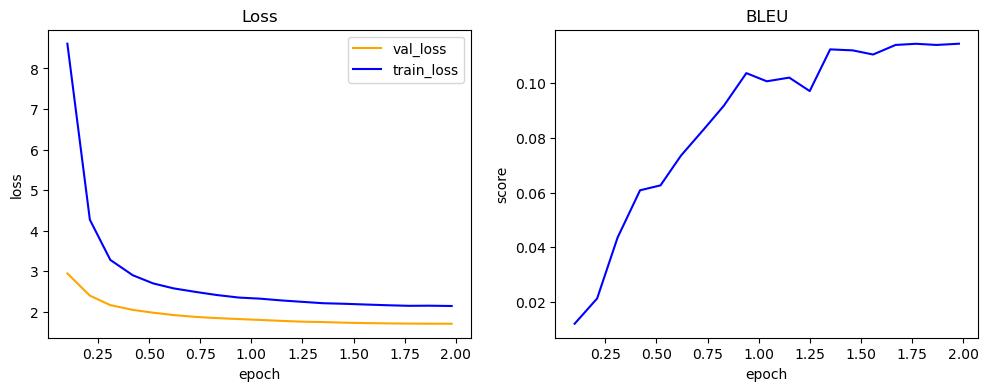

In [16]:
plot_results("./training_logs/mt5_final.txt")

In [21]:
actual_sentences[:5], predicted_sentences[:5]

(['▁ тому ▁времени ▁как ▁ тому ▁исполн илось ▁три надцат ь ▁лет ▁он ▁ уже ▁мог ▁говорит ь ▁на ▁тр ё х ▁язык ах',
  '▁не ▁волн ует ▁что ▁том ▁дела ет ▁со ▁сво ими ▁день гами',
  '▁ ая ▁сов есть ▁призна к ▁ плохо й ▁памят и',
  '▁дума ете ▁он ▁сдела л ▁эт у ▁ работу ▁сам',
  '▁ только ▁вы ▁до бер етесь ▁до ▁ вокзал а ▁вы ▁най дете ▁дорог у ▁без ▁проблем'],
 ['▁том ▁мог ▁бы ▁говорит ь ▁три ▁язык а',
  '▁ я ▁не ▁ знаю ▁что ▁том ▁дела ет ▁с ▁сво им ▁ деньги',
  '▁чист ая ▁памят ь ▁ означа ет ▁ плох ая ▁памят ь',
  '▁ты ▁дума ешь ▁что ▁он ▁сдела л ▁сво й ▁собствен ный ▁job',
  '▁ты ▁ будет ▁ туда ▁ где ▁ты ▁ будет ▁в ▁машин е'])